In [1]:
# RUN Main import block and TODO list

# TODO: see how uri calculated the ridges

# TODO: Perform Histogram equalization - start with it
# TODO: 
# take integral from the Highest peak+-0.005 divide by integral of the entire graph 
# This will be the peakness measure for the PSD ==> The desired ridge index
# TODO:
# take integral from the Highest peak+-0.005 divide by integral of the entire graph - it's the peakness measure for the PSD
# must select a peak above a min threshold in order to ignore noisy frequency
# must ignore peaks above a certain threshold in order to detect meaningful frequency
# run the PSD in moving windows every 200 px (deduced from the below PSD pointing to a freq of 1/0.02=50-> times 4= 200px)
# and medianf the result of the windows
# TODO:
# Another alternative: (with Yariv)
# Run PSD column by column - get the phase, freq, peakness and reconstruct an artificial ridge slice
# from this - reconstruct a "clean" artificial ridge image

%matplotlib inline
import matplotlib.image as img
import matplotlib.pyplot as plt
import numpy as np
import urllib.request
import os
import glob
from scipy import ndimage
from scipy import signal
# import cv2

from PIL import Image, ImageDraw, ImageFont

import mahotas as mh
from mahotas import polygon
# import pymorph as pm

import networkx as nx

from scipy import ndimage as nd
import skimage.transform as transform
import skimage.morphology as mp
import skimage.io as sio
import scipy.misc as sm
from skimage.filters import threshold_otsu, threshold_adaptive
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
from skimage import exposure
from skimage import data, img_as_float
from sklearn.metrics import precision_recall_fscore_support

from bisect import bisect_left
import math
import warnings
import csv
import tensorflow as tf


/anaconda3/envs/tf_gpu2/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# RUN Utility functions
import numpy as np
%matplotlib inline

# One time init
# with open('results.csv', 'w') as csvfile:
#     csvout = csv.writer(csvfile)
#     csvout.writerow(["File", "Model", "Gap", "Slice_size", "Count", "Precision", "Recall", "F-score", "True Count", "Error Rate"])

#BASIC CROP FRAME
X_START = 1000
X_END = 6000
Y_START = 800
Y_END = 4300
BG_2_OBJ_RATIO = 0.91
CUBE_SIZE = 250
ROOT_FOLDER = "/Users/il239838/Downloads/private/Thesis/Papyrus/"
LEARNING_RATE = 0.001
BATCHES = 400
BATCH_SIZE = 50
BREAK_VAL = 1000


# Simple crop by x/y ranges
def crop(image, ymin, ymax, xmin, xmax):
    return image[ymin:ymax, xmin:xmax]

# returns a logical matrix of values beyond a threshld
def thresholded(image, val): 
    return np.logical_and(*[image[...] > val  for t in enumerate([0, 0])])

def find_min_max_without_orphand_pixels(nonzero_dimension, crop_filter=20):
    sorted = np.sort(nonzero_dimension)
    prev=-1
    min_val = sorted[0]
    for i, x in enumerate(sorted[:100]):
        if prev >= 0 and x - prev > crop_filter:
            min_val = x
        prev = x
    prev=-1
    max_val = sorted[-1]
    for i, x in enumerate(sorted[-100:]):
        if prev >= 0 and x - prev > crop_filter:
            max_val = prev
            break
        prev = x
    
    return min_val, max_val

def calc_min_max_coordinates(image, crop_val=50):
    temp = thresholded(image, crop_val)
    temp = temp * 1
    temp = np.nonzero(temp)
    ymin, ymax = find_min_max_without_orphand_pixels(temp[0])
    xmin,xmax = find_min_max_without_orphand_pixels(temp[1])
    return ymin, ymax, xmin, xmax

def calc_min_max_coordinates_dynamic(image, cutoff=1):
    temp = exposure.equalize_adapthist(image, clip_limit=0.03)
    flat = np.sort(np.matrix.getA1(temp))
    sum_all = np.sum(flat)
    index = np.argmin(flat.cumsum() < (sum_all * cutoff))

    temp = thresholded(temp, flat[index])
    temp = temp * 1
    temp = np.nonzero(temp)
    ymin, ymax = find_min_max_without_orphand_pixels(temp[0])
    xmin,xmax = find_min_max_without_orphand_pixels(temp[1])
    return ymin, ymax, xmin, xmax

# initial static crop and a seondary dynamic crop based on signal2noise ratio
def crop_full_scan(image):
    temp = crop(image, Y_START, Y_END, X_START, X_END)
    ymin, ymax, xmin, xmax = calc_min_max_coordinates_dynamic(temp, cutoff=BG_2_OBJ_RATIO)
    temp = crop(image, Y_START+ymin, Y_START+ymax, X_START+xmin, X_START+xmax)
    return temp

def crop_thresholded(image):
    temp = crop(image, 0, image.shape[0]-1, 0, image.shape[1]-1)
    ymin, ymax, xmin, xmax = calc_min_max_coordinates(temp)
    temp = crop(image, ymin, ymax, xmin, xmax)
    return temp

def read_and_crop(image_name):
    if "il239838" in os.getcwd():
        image = img.imread("/Users/il239838/Downloads/private/Thesis/Papyrus/" + image_name)
    else:
        f = urllib.request.urlopen("https://dl.dropboxusercontent.com/s/31b96942qdcn73k/" + image_name)
        image = img.imread(f, format='jpeg')

    # Smart-crop the image to get rid of all the noise and redundant area
    # return crop_full_scan(image)
    cropped = crop_full_scan(image)
    return exposure.equalize_adapthist(cropped, clip_limit=0.03)


# TODO: fix performance!!! http://scikit-image.org/docs/dev/user_guide/tutorial_parallelization.html
def combine_3_images_to_RGB(red, green, blue):
    new_image = np.empty((blue.shape[0],blue.shape[1],3))
    for x in range(0, blue.shape[0]):
        for y in range(0, blue.shape[1]):
            new_image[x,y,0] = red[x,y]
            new_image[x,y,1] = green[x,y]
            new_image[x,y,2] = blue[x,y]
    return new_image

def slice_image_left_edge(original, width=200, rotate=0):
    rot = ndimage.rotate(original, rotate)
    # Slice the left slice of the so-called "blue" image
    left_edge_orig = crop(rot, 1, 1400, 1, width)
    left_edge_orig = crop_thresholded(left_edge_orig)

    # Copy to a new array so we don't thrash the origin
    left_edge = np.empty_like (left_edge_orig)
    np.copyto(left_edge, left_edge_orig)

    # Zero down low level "noise" values
    low_values_indices = left_edge < 30  # Where values are low
    left_edge[low_values_indices] = 0  # All low values set to 0
    return left_edge

def get_best_angle_rotation(original, crop=True, width=200):
    min_var = 99999999999
    best_angle = -10
    for x in range(-5,5):
        if crop:            
            rot_edge = slice_image_left_edge(original, width, x)
        else:
            rot_edge = ndimage.rotate(original, x)
        left_var = np.var(rot_edge, axis=1)
        # left_var = np.apply_along_axis(lambda v: np.var(v[np.nonzero(v)]), 1, rot_edge)
        var_sum = np.sum(left_var)
        if (var_sum < min_var):
            min_var = var_sum
            best_angle = x
    print ("best_angle="+str(best_angle))
    return best_angle

#     import pdb; pdb.set_trace()
def calc_neighbors(slice_map, col, row):
    # import pdb; pdb.set_trace()
    if ((col-1, row) in slice_map and slice_map[(col-1, row)] != None):
        slice_map[(col, row)]["left"] = slice_map[(col-1, row)]
        slice_map[(col-1, row)]["right"] = slice_map[(col, row)]
    if ((col+1, row) in slice_map and slice_map[(col+1, row)] != None):
        slice_map[(col, row)]["right"] = slice_map[(col+1, row)]
        slice_map[(col+1, row)]["left"] = slice_map[(col, row)]
    if ((col, row-1) in slice_map and slice_map[(col, row-1)] != None):
        slice_map[(col, row)]["top"] = slice_map[(col, row-1)]
        slice_map[(col, row-1)]["bottom"] = slice_map[(col, row)]
    if ((col, row+1) in slice_map and slice_map[(col, row+1)] != None):
        slice_map[(col, row)]["bottom"] = slice_map[(col, row+1)]
        slice_map[(col, row+1)]["top"] = slice_map[(col, row)]
    


def VAL_create_cube(name, raw, x, y):
    cube = {}
    cube["cube"] = raw
    cube["file"] = name
    if name.find('P') == 0:
        cube["index"] = int(name[name.find('P')+1:name.find('P')+4]) * 1000 + int(name[name.find('Fg')+2:name.find('Fg')+5])
    else:
#        print("Found a ZERO index cube with the name:"+name)
        cube["index"] = 0
    cube["top_row"] = x
    cube["left_col"] = y
    cube["right_col"] = y + CUBE_SIZE
    return cube
    

ZERO_CUBE = VAL_create_cube("ZERO", np.zeros((CUBE_SIZE, CUBE_SIZE), dtype=np.int), -1, -2)

# slice an image to cubes with 250X250 pixel size
def VAL_slice_to_static_slices(name, cropped_original):
    structure = []
    # cropped_original = cropped_original / 256 # divide by 256 to "normalize" between 0 and 1

    # import pdb; pdb.set_trace()
    x, y = cropped_original.shape
    # print (x,y)
    n = 0
    # every 250 pixels on the x axis == rows
    while ((n + 1) * CUBE_SIZE < x):
        m = 0
        # every 250 pixels on the y axis == cols
        while ((m + 1) * CUBE_SIZE < y):
            if ((m == 0) or ((m + 2) * CUBE_SIZE >= y)): # Only keep the left and right edges of the piece for matching!!
                # cut a cube of 250X250
                cube = (crop(cropped_original, n * CUBE_SIZE, (n + 1) * CUBE_SIZE, m * CUBE_SIZE, (m + 1) * CUBE_SIZE))
                # keep only cubes for which half of the pixels have some "color"
                # import pdb; pdb.set_trace()
                # print(np.median(cube))
                if np.median(cube) > 0.2: # aligned with the normalization 0.2 correlates to 50
                    # keep the cube
                    new_cube = VAL_create_cube(name, cube, n * CUBE_SIZE, m * CUBE_SIZE)
                    new_cube["col"] = m
                    new_cube["row"] = n
                    if ((m + 2) * CUBE_SIZE >= y):
                        new_cube["last"] = True
                    else:
                        new_cube["last"] = False
                    structure.append(new_cube)
            m += 1
        n += 1
            
    # return the data structure with all the cubes and the counters of the rows and columns
    return structure

def pad_above(original, above, amount):
    res = np.insert(original["cube"], np.zeros(amount), above["cube"][-amount:], axis=0)
    res = np.delete(res, np.arange(CUBE_SIZE,CUBE_SIZE+amount), axis=0)
    return create_cube(res, original["top_row"] - amount, original["left_col"])
  

def pad_below(original, below, amount):
    res = np.insert(original["cube"], np.full(amount, CUBE_SIZE), below["cube"][:amount], axis=0)
    res = np.delete(res, np.arange(0, amount), axis=0)
    return create_cube(res, original["top_row"] + amount, original["left_col"])

def pad_left(original, left, amount):
    res = np.insert(original["cube"], np.zeros(amount, dtype=int), left["cube"][:,-amount:], axis=1)
    res = np.delete(res, np.arange(CUBE_SIZE, CUBE_SIZE+amount), axis=1)
    return create_cube(res, original["top_row"], original["left_col"] - amount)

def pad_right(original, right, amount):
    res = np.insert(original["cube"], [CUBE_SIZE], right["cube"][:,:amount], axis=1)
    res = np.delete(res, np.arange(0, amount), axis=1)
    return create_cube(res, original["top_row"], original["left_col"] + amount)
    

# "Shave" the right edge of the cube with <gap> pixels and pad with zeros on the left
def shave_right(original, amount):
    return pad_left(original, ZERO_CUBE, amount)
    

# "Shave" the left edge of the cube with <gap> pixels and pad with zeros on the right    
def shave_left(original, amount):
    return pad_right(original, ZERO_CUBE, amount)
    

# concatenate cubes 
def VAL_concatenate_cubes(left, right, slice_size):
    right_img = right["cube"]
    # if the left cube is matched to another left cube (or right cube to another right cube) then rotate the right
    # cube by 180 so we try to match it upside down, covering the option that the cube was pictured rotated
    if ((left["col"] == 0 and right["col"] == 0) or (left["last"] and right["last"])):
        right_img = np.rot90(right["cube"], 2);
    con = np.concatenate((left["cube"][:,-slice_size:], right_img[:,:slice_size]), axis=1)
    x_delta = right["top_row"] - left["top_row"]
    y_delta = right["left_col"] - left["right_col"] 
    return con, x_delta, y_delta, left["file"], right["file"]
    

# concatenate cubes while artificially creating a gap between them. Pad the other end of the cube with zeros
def concatenate_cubes_zero_pad_gaps(left_orig, right_orig, gap):
    left = left_orig if gap == 0 else shave_right(left_orig, gap)
    right = right_orig if gap == 0 else shave_left(right_orig, gap)
    return concatenate_cubes(left, right)    

# concatenate cubes while artificially creating a gap between them. Pad the other end of the cobe with the nearby
# continuation of the cubes
def concatenate_cubes_with_gap(left_orig, right_orig, gap, left_pad, right_pad, slice_size):
    # import pdb; pdb.set_trace()
    left = left_orig if gap == 0 else pad_left(left_orig, left_pad, gap)
    right = right_orig if gap == 0 else pad_right(right_orig, right_pad, gap)
    return concatenate_cubes(left, right, slice_size)        

# convert the data structure of cubes into a train set of 2 arrays of images and labels
# each image is a concatanation of 2 images from the original cubes set, covering all combinations of images
# effectively creating Nx(N-1) images
def VAL_build_train_set(cubes, slice_size, folder, curr):
    for root, dirs, files in os.walk(folder):
        for f in files:
            os.unlink(os.path.join(root, f))
    # import pdb; pdb.set_trace()
    warnings.filterwarnings("ignore")

    train_imgs = []
    train_x_delta = []
    train_y_delta = []
    train_x_file = []
    train_y_file = []
    # iterate over the others (effectively n^2)
    for adj in cubes:
        if (adj["file"] != curr["file"]) and curr["index"] < adj["index"]: # no need to test against self and avoid checking from both directions
            # import pdb; pdb.set_trace()
            # append the a§djacent image to the current image
            conc, x_delta, y_delta, x_file, y_file = VAL_concatenate_cubes(curr, adj, slice_size)
            output = folder+x_file[:x_file.rfind(' ')]+"_"+str(curr["top_row"])+"_"+str(curr["left_col"])+"---"+y_file[:y_file.rfind(' ')]+"_"+str(adj["top_row"])+"_"+str(adj["left_col"])
            np.save(output, conc)
            train_imgs.append(output)
            train_x_delta.append(x_delta)
            train_y_delta.append(y_delta)
            train_x_file.append(x_file)
            train_y_file.append(y_file)

    warnings.filterwarnings("default")
    return train_imgs,train_x_delta, train_y_delta, train_x_file, train_y_file

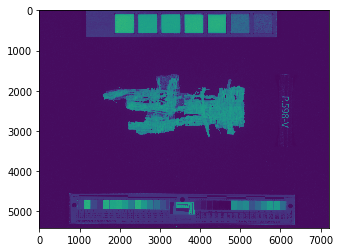

In [3]:
cubesize = 250

img1 = img.imread("/Users/il239838/Downloads/private/Thesis/Papyrus/jm_4a36716c764b6d6b4c442f464b3342347436653838673d3d/P598-Fg009-R/" + "P598-Fg009-R-C01-R01-D07012014-T124244-LR924__012.jpg")
img2 = img.imread("/Users/il239838/Downloads/private/Thesis/Papyrus/jm_4a36716c764b6d6b4c442f464b3342347436653838673d3d/P598-Fg009-V/" + "P598-Fg009-V-C01-R01-D07012014-T125159-LR924__012.jpg")
image3 = img.imread("/Users/il239838/Downloads/private/Thesis/Papyrus/jm_4a36716c764b6d6b4c442f464b3342347436653838673d3d/P589-Fg003-V/" + "P589-Fg003-V-C01-R01-D12022013-T114206-LR924__012.jpg")

x1start = 0
x1end = 6000
y1start = 0
y1end = 4300

image1 = crop(img1, y1start, y1end, x1start, x1end)
plt.imshow(img2)


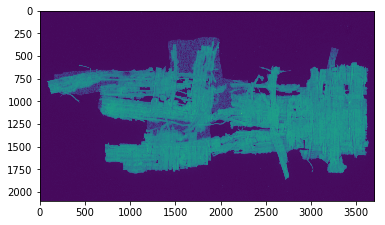

In [4]:
x2start = 1500 #1000
x2end = 5200 #6000
y2start = 1300 #700
y2end = 3400 #4300

image2 = crop(img2, 1300, 3400, 1500, 5200)
plt.imshow(image2)

/anaconda3/envs/tf_gpu2/lib/python3.6/site-packages/skimage/filters/thresholding.py:222: skimage_deprecation: Function ``threshold_adaptive`` is deprecated and will be removed in version 0.15. Use ``threshold_local`` instead.
  def threshold_adaptive(image, block_size, method='gaussian', offset=0,
/anaconda3/envs/tf_gpu2/lib/python3.6/site-packages/skimage/filters/thresholding.py:224: UserWarning: The return value of `threshold_local` is a threshold image, while `threshold_adaptive` returned the *thresholded* image.
  warn('The return value of `threshold_local` is a threshold image, while '


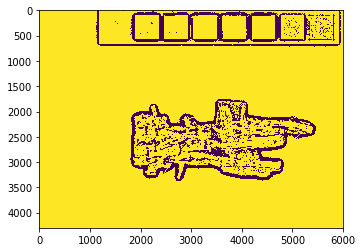

In [5]:
from skimage.filters import threshold_otsu, threshold_adaptive

binary_adaptive1 = threshold_adaptive(image1, 251, offset=5)

plt.imshow(binary_adaptive1)


/anaconda3/envs/tf_gpu2/lib/python3.6/site-packages/skimage/filters/thresholding.py:222: skimage_deprecation: Function ``threshold_adaptive`` is deprecated and will be removed in version 0.15. Use ``threshold_local`` instead.
  def threshold_adaptive(image, block_size, method='gaussian', offset=0,
/anaconda3/envs/tf_gpu2/lib/python3.6/site-packages/skimage/filters/thresholding.py:224: UserWarning: The return value of `threshold_local` is a threshold image, while `threshold_adaptive` returned the *thresholded* image.
  warn('The return value of `threshold_local` is a threshold image, while '


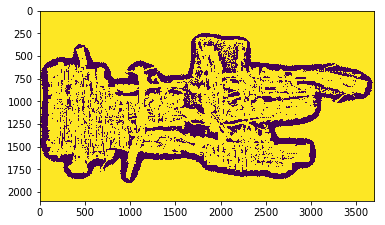

In [6]:
from skimage.filters import threshold_otsu, threshold_adaptive

binary_adaptive2 = threshold_adaptive(image2, 251, offset=5)

plt.imshow(binary_adaptive2)

flipped2 = binary_adaptive2[:,::-1]
plt.imshow(flipped2)


/anaconda3/envs/tf_gpu2/lib/python3.6/site-packages/skimage/filters/thresholding.py:222: skimage_deprecation: Function ``threshold_adaptive`` is deprecated and will be removed in version 0.15. Use ``threshold_local`` instead.
  def threshold_adaptive(image, block_size, method='gaussian', offset=0,
/anaconda3/envs/tf_gpu2/lib/python3.6/site-packages/skimage/filters/thresholding.py:224: UserWarning: The return value of `threshold_local` is a threshold image, while `threshold_adaptive` returned the *thresholded* image.
  warn('The return value of `threshold_local` is a threshold image, while '


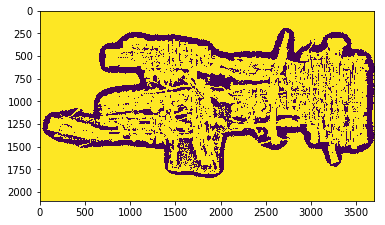

In [7]:
from skimage.filters import threshold_otsu, threshold_adaptive

binary_adaptive2 = threshold_adaptive(image2, 251, offset=5)

plt.imshow(binary_adaptive2)

flipped2 = binary_adaptive2[::-1]
plt.imshow(flipped2)


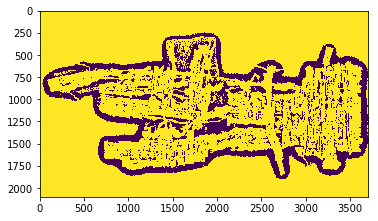

In [9]:
plt.figure(figsize=(20, 6))
ax2 = plt.subplot(1, 3, 1)
plt.imshow(binary_adaptive2)#, cmap=plt.cm.gray)
cubex = 250
cubey = 750
# rect = plt.Rectangle((cubex, cubey), 250, 250, edgecolor='r', facecolor='r')
# ax2.add_patch(rect)
# plt.show()


In [10]:
from skimage.feature import match_template
result = match_template(binary_adaptive1, flipped2)
ij = np.unravel_index(np.argmax(result), result.shape)
x, y = ij[::-1]

/anaconda3/envs/tf_gpu2/lib/python3.6/site-packages/skimage/feature/template.py:180: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return response[slices]


/anaconda3/envs/tf_gpu2/lib/python3.6/site-packages/matplotlib/axes/_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


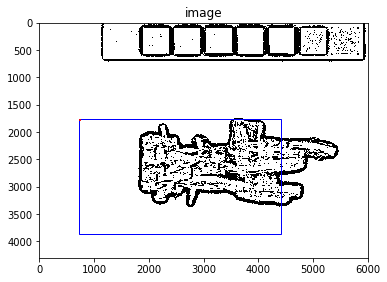

In [11]:
fig = plt.figure(figsize=(20, 6))
ax2 = plt.subplot(1, 3, 1, adjustable='box-forced')

ax2.imshow(binary_adaptive1, cmap=plt.cm.gray)
# ax2.set_axis_off()
ax2.set_title('image')
# highlight matched region
height, width = flipped2.shape
rect = plt.Rectangle((x, y), width, height, edgecolor='b', facecolor='none')
ax2.add_patch(rect)
rect = plt.Rectangle((x, y), 20, 20, edgecolor='r', facecolor='r')
ax2.add_patch(rect)
plt.show()

In [12]:
ij

(1756, 723)

In [13]:
result[ij]

0.1740705527325036

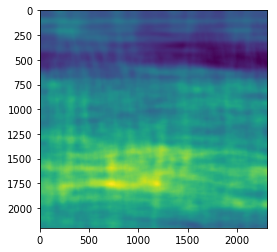

In [14]:
plt.imshow(result)


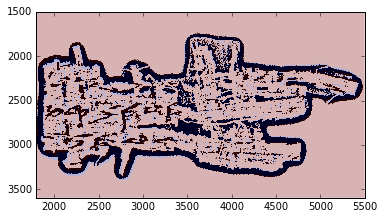

In [78]:
# fig = plt.figure(figsize=(20, 6))
# ax2 = plt.subplot(1, 3, 1, adjustable='box-forced')

# ax2.imshow(flipped1, cmap=plt.cm.gray)
# # ax2.set_axis_off()
# ax2.set_title('image')
# # highlight matched region
# rect = plt.imshow(binary_adaptive2)
# ax2.add_patch(rect)

plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.imshow(binary_adaptive1, cmap=plt.cm.gray)
plt.imshow(flipped2, 'jet', \
           extent=[ij[1], ij[1]+flipped2.shape[1], ij[0]+flipped2.shape[0], ij[0]], \
           interpolation='none', alpha=0.3)
plt.show()

# height, width = binary_adaptive2.shape
# rect = plt.Rectangle((x, y), width, height, edgecolor='b', facecolor='none')
# ax2.add_patch(rect)
# rect = plt.Rectangle((x, y), 20, 20, edgecolor='r', facecolor='r')
# ax2.add_patch(rect)
# plt.show()

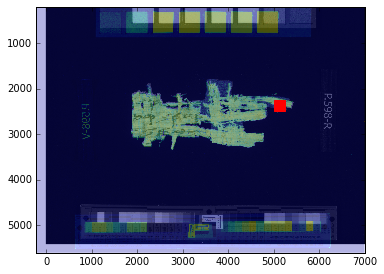

In [79]:
# fig = plt.figure(figsize=(20, 6))
# ax2 = plt.subplot(1, 3, 1, adjustable='box-forced')

# ax2.imshow(flipped1, cmap=plt.cm.gray)
# # ax2.set_axis_off()
# ax2.set_title('image')
# # highlight matched region
# rect = plt.imshow(binary_adaptive2)
# ax2.add_patch(rect)

plt.figure(figsize=(20, 6))
ax2 = plt.subplot(1, 3, 1)
plt.imshow(img1, cmap=plt.cm.gray)
minx = x1start + ij[1] - (img2.shape[1] - x2end) 
miny = y1start + ij[0] - y2start 
# import pdb; pdb.set_trace()

flipped22 = img2[:,::-1]
plt.imshow(flipped22, 'jet', \
           extent=[minx, minx+flipped22.shape[1], miny+flipped22.shape[0], miny], \
           interpolation='none', alpha=0.3)

reverse_cubex = x1start + ij[1] + (flipped2.shape[1] - cubex - cubesize)
reverse_cubey = y1start + ij[0] + cubey
rect = plt.Rectangle((reverse_cubex, reverse_cubey), cubesize, cubesize, edgecolor='r', facecolor='r')
ax2.add_patch(rect)

plt.show()

# height, width = binary_adaptive2.shape
# rect = plt.Rectangle((x, y), width, height, edgecolor='b', facecolor='none')
# ax2.add_patch(rect)
# rect = plt.Rectangle((x, y), 20, 20, edgecolor='r', facecolor='r')
# ax2.add_patch(rect)
# plt.show()